In [1]:
import weka.core.jvm as jvm
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/home/sebastian/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/home/sebastian/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/home/sebastian/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/home/sebastian/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar', '/home/sebastian/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [20]:
from weka.core.converters import Loader
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
loader = Loader(classname="weka.core.converters.ArffLoader")
data = loader.load_file("student-mat_train_preproc.arff")
data.class_is_last()
print(data)

@relation 'student-merged-weka.filters.unsupervised.attribute.Reorder-R1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,12-weka.filters.unsupervised.attribute.Discretize-D-F-B2-M-1.0-R32-precision6-weka.filters.unsupervised.attribute.Remove-R30-31-weka.filters.unsupervised.attribute.Reorder-R1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,30-weka.filters.unsupervised.instance.RemoveRange-V-R1-395-weka.filters.unsupervised.instance.RemoveRange-V-R1-200-weka.filters.unsupervised.attribute.Remove-R1,3-10,12-13,15-19,21-25,27,30'

@attribute sex {F,M}
@attribute reason {course,other,home,reputation}
@attribute failures numeric
@attribute higher {yes,no}
@attribute Dalc numeric
@attribute health numeric
@attribute absences numeric
@attribute G3_1 {'\'(-inf-11.5]\'','\'(11.5-inf)\''}

@data
F,course,0,yes,1,3,6,'\'(-inf-11.5]\''
F,course,0,yes,1,3,4,'\'(-inf-11.5]\''
F,other,3,yes,2,3,10,'\'(-inf-11.5]\''
F,home,0,yes,1,5

In [4]:
def measures(wisdom):
    dct={}
    full_wisdom=wisdom["True positive"]+wisdom["True negative"]+wisdom["False positive"]+wisdom["False negative"]
    dct['Accuracy']=(wisdom["True positive"]+wisdom["True negative"])/full_wisdom
    dct['Precision']=wisdom["True positive"]/(wisdom["True positive"]+wisdom["False positive"])
    dct['Recall']=wisdom["True positive"]/(wisdom["True positive"]+wisdom["False negative"])
    dct['Specifity']=wisdom["True negative"]/(wisdom["True negative"]+wisdom["False positive"])
    dct['F1']=2*dct['Recall']*dct['Precision']/(dct['Precision']+dct['Recall'])
    
    dct['Balanced Accuracy']=(dct['Recall']+dct['Specifity'])/2
    return dct

In [5]:
def show_all(lst):
    for i, x in enumerate(lst):
        if (type(x)==type(1.2)):
            print (f'{x:.4f}', end='')
        else:
            print (f'{x}', end='')
        if (i!=len(lst)-1):
            print (' & ', end='')
    print('\\\\ \\hline')

def create_tex_table(data, cost, done):
    correct=["Accuracy", "F1", "Balanced Accuracy"]
    mine={**data}
    for x in correct:
        mine[x]=cost[x]
    
    if (done==0):
        map_names={"True positive":"TP", "True negative":"TN", "False positive":"FP", "False negative": "FN"}
        show_all([map_names[x] if x in map_names else x for x in mine])
    show_all([mine[x] for x in mine])
    
    return data

In [34]:
END_M=6
def make_classification(data, test_data):
    results=[]
    D=10
    done=0
    for M in range(2, END_M):
        for B in range(0, 2):
            for C in range(1, D):
                opts=["-C", str(C/D), "-M", str(M)]
                if (B==1):
                    opts.append("-B")
                cls = Classifier(classname="weka.classifiers.trees.J48", options=opts)
                cls.build_classifier(data)
                
                truth_of_the_truth={"Binary Split": B, "Confidence factor": C/D, "Minimum objects": M, 
                                    "True positive":0, "False positive":0, "False negative":0, "True negative":0}

                for index, inst in enumerate(test_data):
                    real=inst.values[-1]
                    pred = cls.classify_instance(inst)
                    #print(f'Reality: {real}, Predict: {str(pred)}')
                    if (real==pred and real==1.0):
                        truth_of_the_truth["True positive"]+=1
                    if (real==pred and real==0.0):
                        truth_of_the_truth["True negative"]+=1
                    if (real!=pred and real==1.0):
                        truth_of_the_truth["False negative"]+=1
                    if (real!=pred and real==0.0):
                        truth_of_the_truth["False positive"]+=1
                #print(truth_of_the_truth)
                res=measures(truth_of_the_truth)
                #print(res)
                create_tex_table(truth_of_the_truth, res, done)
                results.append({**truth_of_the_truth, **res})
                done+=1
    return results

In [35]:
data = loader.load_file("student-mat_train_preproc.arff")
data.class_is_last()

test_data=loader.load_file("student-mat_test_preproc.arff")
test_data.class_is_last()
rs=make_classification(data, test_data)

Binary Split & Confidence factor & Minimum objects & TP & FP & FN & TN & Accuracy & F1 & Balanced Accuracy\\ \hline
0 & 0.1000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
0 & 0.2000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
0 & 0.3000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
0 & 0.4000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
0 & 0.5000 & 2 & 27 & 28 & 50 & 90 & 0.6000 & 0.4091 & 0.5567\\ \hline
0 & 0.6000 & 2 & 28 & 35 & 49 & 83 & 0.5692 & 0.4000 & 0.5335\\ \hline
0 & 0.7000 & 2 & 28 & 35 & 49 & 83 & 0.5692 & 0.4000 & 0.5335\\ \hline
0 & 0.8000 & 2 & 28 & 35 & 49 & 83 & 0.5692 & 0.4000 & 0.5335\\ \hline
0 & 0.9000 & 2 & 28 & 35 & 49 & 83 & 0.5692 & 0.4000 & 0.5335\\ \hline
1 & 0.1000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
1 & 0.2000 & 2 & 31 & 37 & 46 & 81 & 0.5744 & 0.4276 & 0.5445\\ \hline
1 & 0.3000 & 2 & 27 & 29 & 50 & 89 & 0.5949 & 0.4060 & 0.5524\\ \hline
1 & 0.4000 & 2 & 26 & 23 & 51 & 

In [104]:
def create_dynamic(data, cost_name, axis, rs=0):
    dp=np.zeros((END_M-2, 9), dtype=float)
    for x in data:
        dp[x["Minimum objects"]-2][int(x["Confidence factor"]*10)-1]=x[cost_name]
    zy=True if data[0]['Binary Split']==1 else False
    sns.heatmap(dp, ax=axis)
    axis.set_title(f'{cost_name} for given confidence factor, MinNumObjects and binarySplits={zy}')
    axis.set_ylabel('Minimal Number of Objects')
    axis.set_xlabel('Confidence Factor')
    axis.set_xticklabels([x/10 for x in range(1, 10)])
    axis.set_yticklabels([x for x in range(2, 6)])

In [105]:
def create_six_plots(rs, costs):
    rs_1=[x for x in rs if x['Binary Split']==1]
    rs_0=[x for x in rs if x['Binary Split']==0]

    fig, ax=plt.subplots(len(costs) ,2)
    fig.set_size_inches(30,30)

    for i, x in enumerate(costs):
        create_dynamic(rs_0, x, ax[i][0])
        create_dynamic(rs_1, x, ax[i][1])

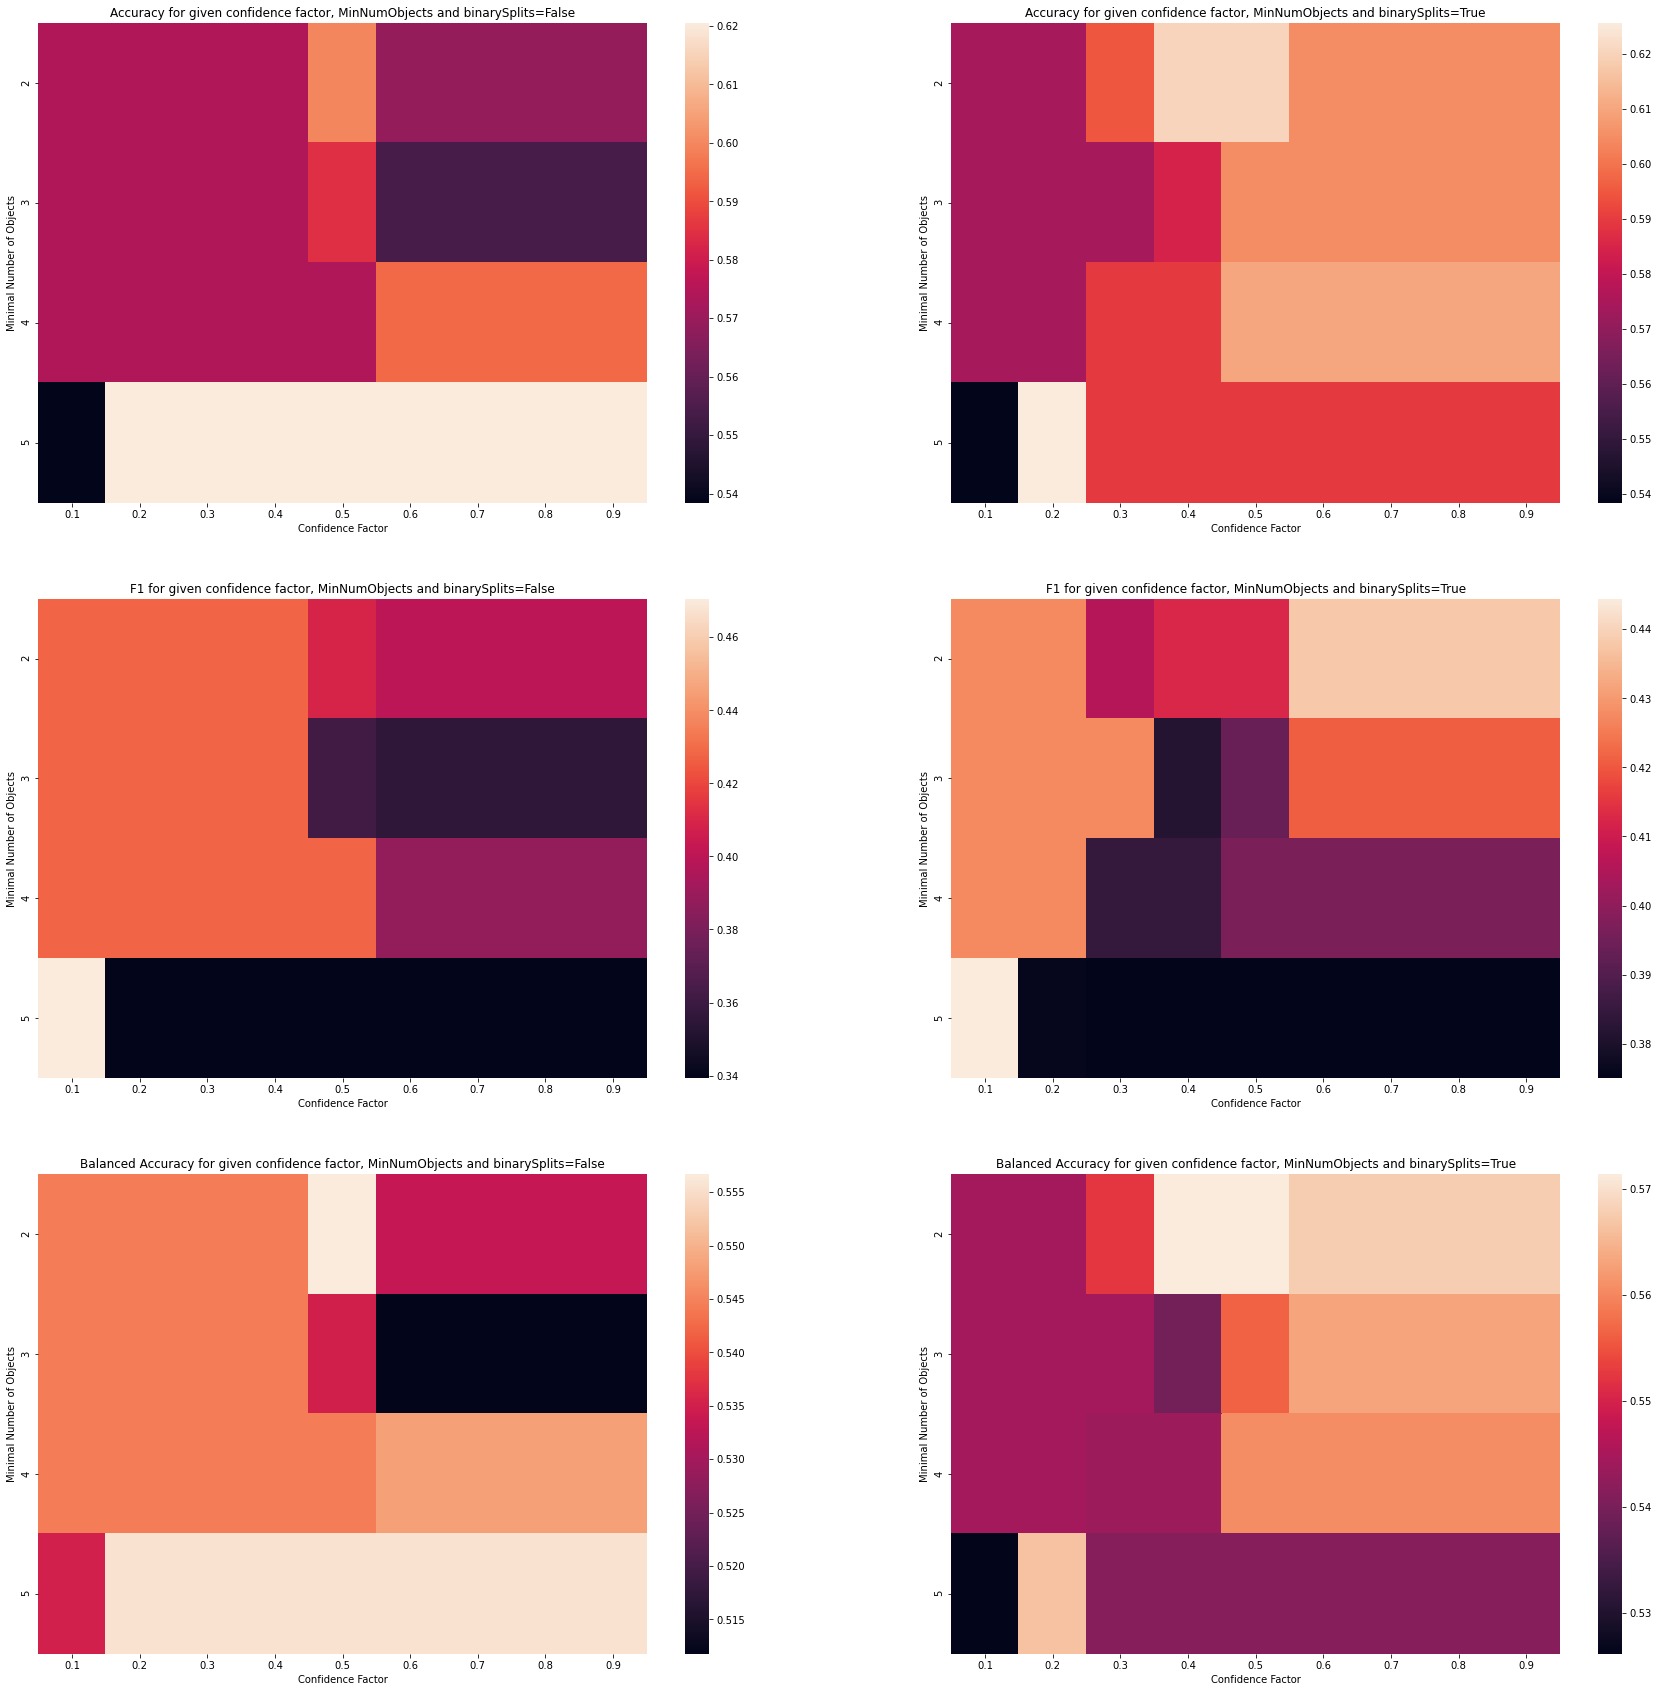

In [106]:
create_six_plots(rs, ['Accuracy', 'F1', 'Balanced Accuracy'])
plt.show()

In [8]:
data = loader.load_file("student-mat_train.arff")
data.class_is_last()

test_data=loader.load_file("student-mat_test.arff")
test_data.class_is_last()
make_classification(data, test_data)

Binary Split & Confidence factor & Minimum objects & TP & FP & FN & TN & Accuracy & F1 & Balanced Accuracy\\ \hline
0 & 0.1000 & 2 & 29 & 48 & 48 & 70 & 0.5077 & 0.3766 & 0.4849\\ \hline
0 & 0.2000 & 2 & 29 & 48 & 48 & 70 & 0.5077 & 0.3766 & 0.4849\\ \hline
0 & 0.3000 & 2 & 29 & 48 & 48 & 70 & 0.5077 & 0.3766 & 0.4849\\ \hline
0 & 0.4000 & 2 & 29 & 49 & 48 & 69 & 0.5026 & 0.3742 & 0.4807\\ \hline
0 & 0.5000 & 2 & 28 & 49 & 49 & 69 & 0.4974 & 0.3636 & 0.4742\\ \hline
0 & 0.6000 & 2 & 28 & 49 & 49 & 69 & 0.4974 & 0.3636 & 0.4742\\ \hline
0 & 0.7000 & 2 & 28 & 49 & 49 & 69 & 0.4974 & 0.3636 & 0.4742\\ \hline
0 & 0.8000 & 2 & 28 & 49 & 49 & 69 & 0.4974 & 0.3636 & 0.4742\\ \hline
0 & 0.9000 & 2 & 28 & 49 & 49 & 69 & 0.4974 & 0.3636 & 0.4742\\ \hline
1 & 0.1000 & 2 & 36 & 41 & 41 & 77 & 0.5795 & 0.4675 & 0.5600\\ \hline
1 & 0.2000 & 2 & 36 & 41 & 41 & 77 & 0.5795 & 0.4675 & 0.5600\\ \hline
1 & 0.3000 & 2 & 37 & 48 & 40 & 70 & 0.5487 & 0.4568 & 0.5369\\ \hline
1 & 0.4000 & 2 & 37 & 48 & 40 & 